In [30]:
import os
import getpass
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt.tool_executor import ToolExecutor
from langchain_core.agents import AgentAction, AgentFinish
from IPython.display import Image
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod



In [4]:
def initialize_llm(**kwargs):
    # initialize llm
    llm = AzureChatOpenAI(
        deployment_name=os.environ["AZURE_OPENAI_DEPLOYMENT"],
        api_key=os.environ["AZURE_OPENAI_API_KEY"],
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        api_version=os.environ["AZURE_OPENAI_API_VERSION"],
        **kwargs
    )
    return llm


In [6]:
from dotenv import load_dotenv
load_dotenv()

True

In [11]:
llm = initialize_llm(temperature=0.5, streaming=True)
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)
tools = [tavily_tool]
tool_executor = ToolExecutor(tools=tools)

In [15]:
# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/openai-functions-agent")
print(prompt)

input_variables=['agent_scratchpad', 'input'] input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]} metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'openai-functions-agent', 'lc_hub_commit_hash': 'a1655024b06afbd95d17449f21316291e0726f13dcfaf990cc0d18087ad689a5'} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant')), MessagesPlaceholder(variable_name='

In [16]:
# Construct the OpenAI Functions agent
agent_runnable = create_openai_functions_agent(llm, tools, prompt)

In [17]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    # The input string
    input: str
    # The list of previous messages in the conversation
    chat_history: list[BaseMessage]
    # The outcome of a given call to the agent
    # Needs `None` as a valid type, since this is what this will start as
    agent_outcome: Union[AgentAction, AgentFinish, None]
    # List of actions and corresponding observations
    # Here we annotate this with `operator.add` to indicate that operations to
    # this state should be ADDED to the existing values (not overwrite it)
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [18]:
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor

# This a helper class we have that is useful for running tools
# It takes in an agent action and calls that tool and returns the result
tool_executor = ToolExecutor(tools)


# Define the agent
def run_agent(data):
    agent_outcome = agent_runnable.invoke(data)
    return {"agent_outcome": agent_outcome}


# Define the function to execute tools
def execute_tools(data):
    # Get the most recent agent_outcome - this is the key added in the `agent` above
    agent_action = data["agent_outcome"]
    output = tool_executor.invoke(agent_action)
    return {"intermediate_steps": [(agent_action, str(output))]}


# Define logic that will be used to determine which conditional edge to go down
def should_continue(data):
    # If the agent outcome is an AgentFinish, then we return `exit` string
    # This will be used when setting up the graph to define the flow
    if isinstance(data["agent_outcome"], AgentFinish):
        return "end"
    # Otherwise, an AgentAction is returned
    # Here we return `continue` string
    # This will be used when setting up the graph to define the flow
    else:
        return "continue"

In [19]:
from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

In [23]:
#plot the graph
app.get_graph().print_ascii()


               +-----------+            
               | __start__ |            
               +-----------+            
                      *                 
                      *                 
                      *                 
                 +-------+              
                 | agent |              
                 +-------+*             
               ***         ***          
              *               *         
            **                 ***      
+-----------------+               *     
| should_continue |               *     
+-----------------+*              *     
          *         *****         *     
          *              ***      *     
          *                 ***   *     
    +---------+             +--------+  
    | __end__ |             | action |  
    +---------+             +--------+  


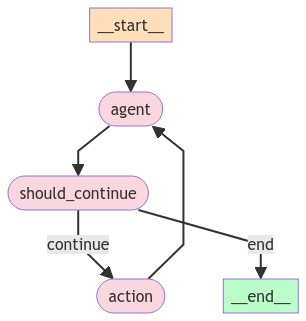

In [31]:
Image(app.get_graph().draw_mermaid_png(
    draw_method=MermaidDrawMethod.API,
))

In [20]:
inputs = {"input": "what is the weather in sf", "chat_history": []}
for s in app.stream(inputs):
    print(list(s.values())[0])
    print("----")

{'agent_outcome': AgentActionMessageLog(tool='tavily_search_results_json', tool_input={'query': 'weather in San Francisco'}, log="\nInvoking: `tavily_search_results_json` with `{'query': 'weather in San Francisco'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "query": "weather in San Francisco"\n}', 'name': 'tavily_search_results_json'}}, response_metadata={'finish_reason': 'function_call'}, id='run-400b0e8c-7f6d-4107-8652-defeff129cb4-0')])}
----
{'intermediate_steps': [(AgentActionMessageLog(tool='tavily_search_results_json', tool_input={'query': 'weather in San Francisco'}, log="\nInvoking: `tavily_search_results_json` with `{'query': 'weather in San Francisco'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "query": "weather in San Francisco"\n}', 'name': 'tavily_search_results_json'}}, response_metadata={'finish_reason': 'function_call'}, id='run-400b0e8c-7f6d-4107-8652-defe